In [1]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("white")
# plt.rcParams['font.family'] = "Liberation Sans"
plt.rcParams['font.size'] = 16
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
from load_data import load_expression, load_dataset
from model import SpiceMix

from Result import SpiceMixResult

In [6]:
synthetic_spiral_result = SpiceMixResult(
    path2dataset='../../data/synthetic_data_spiral/synthetic_500_100_20_30_0_0_',
    result_filename="results_with_spatial.hdf5",
    neighbor_suffix="",
)

Result file = ../../data/synthetic_data_spiral/synthetic_500_100_20_30_0_0_/results/results_with_spatial.hdf5


AttributeError: 'SpiceMixResult' object has no attribute 'replicate_names'

Found 470 iterations from ../../data/synthetic_data_spiral/synthetic_500_100_20_30_0_0_/results/results_with_spatial.hdf5


NameError: name 'label' is not defined

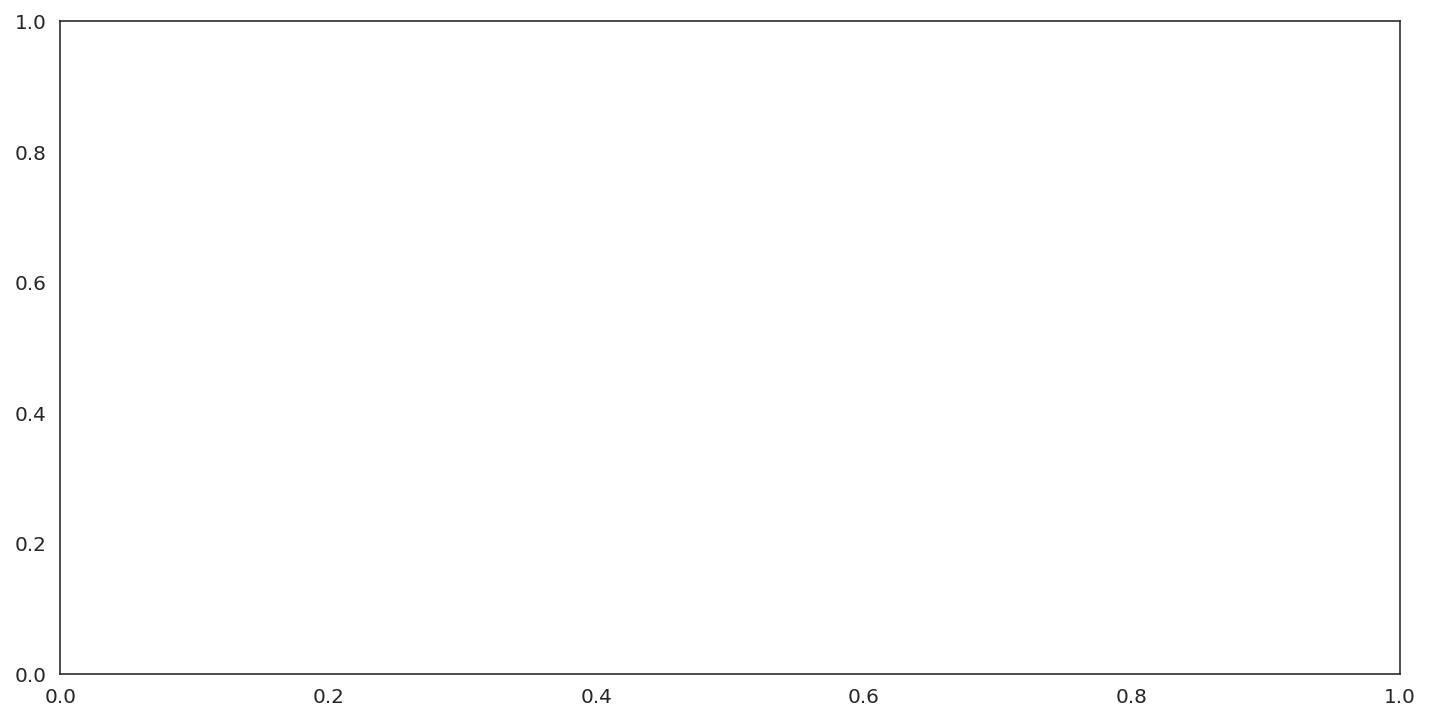

In [4]:
# Prior to downstream analysis, we should make sure the models have converged
fig, ax = plt.subplots(figsize=(12, 6))
synthetic_spiral_result.plot_convergence(ax, label='Spiral Simulation', c='C0')
plt.title('Q function')
plt.xlabel('Iteration')
plt.ylabel('Q decreament')
plt.yscale('log')
plt.legend()

In [5]:
# Load latent states for all cells estimated by the last iteration of SpiceMix/NMF
obj_SpiceMix.loadLatentStates(iiter=-1)

Iteration 470


optimal K = 2
#clusters = 2, #-1 = 0


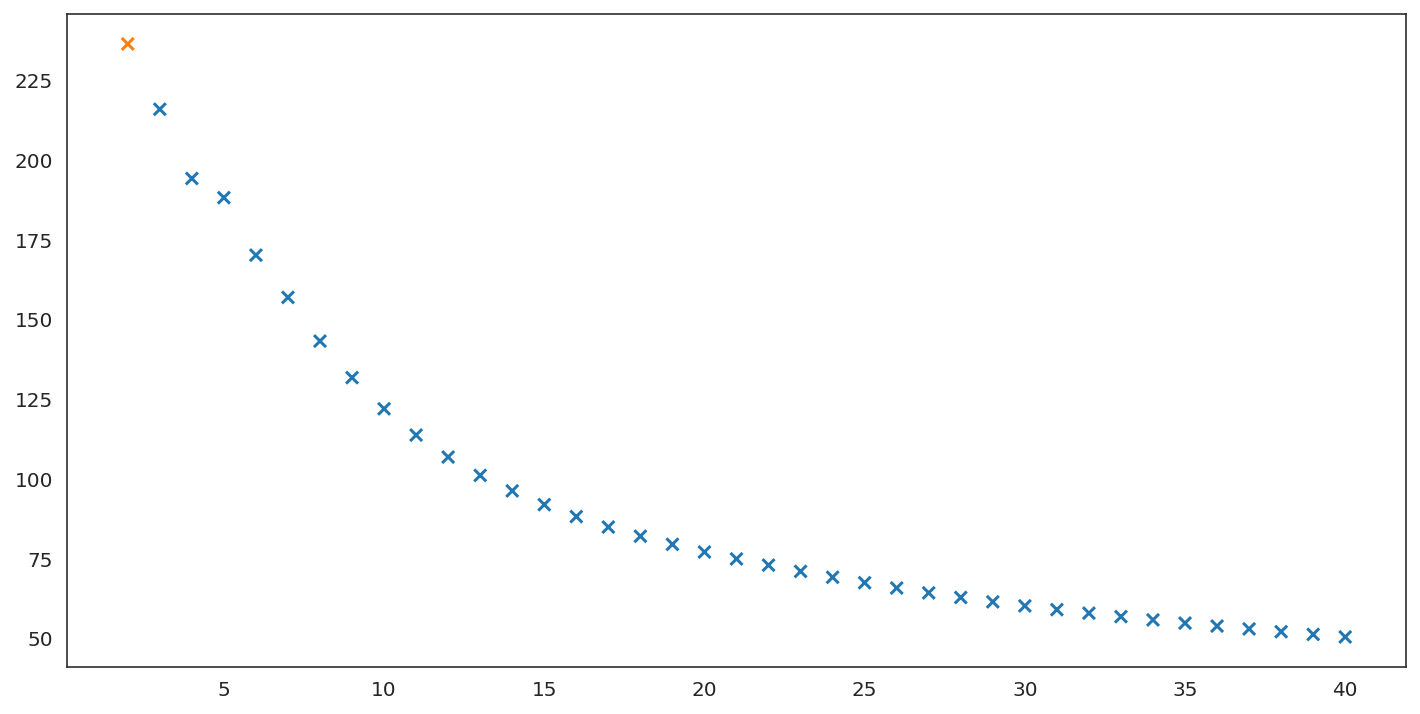

In [6]:
# Do hierarchical clustering on ALL cells in the latent space
# TODO: accelerate this function for datasets of 10k+ cells 
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
obj_SpiceMix.clustering(axes, K_range=np.arange(2, 41))

In [7]:
# Assign a name (a str) to each raw cluster (a natural number starting from 0)
# To merge raw clusters, assign the same name to them
obj_SpiceMix.annotateClusters({
    8: 'NA', 9: 'HPC', 0: 'eL2/3', 6: 'eL4', 10: 'eL5', 12: 'eL6a', 7: 'eL6b', 3: 'eL6c',
    16: 'PVALB', 13: 'SST', 4: 'VIP',
    2: 'Astro', 5: 'Astro/Oligo', 1: 'Oligo-1', 14: 'Oligo-2', 11: 'SMC', 15: 'Endo',
})

# Assign a custom color to each cluster
obj_SpiceMix.assignColors('cluster', {
    'NA': 'black',
    'HPC': 'sandybrown', 'eL2/3': 'lightskyblue', 'eL4': 'mediumspringgreen',
    'eL5': 'palegreen', 'eL6a': 'greenyellow', 'eL6b': 'darkseagreen', 'eL6c': 'burlywood',
    'PVALB': 'orangered', 'SST': 'firebrick', 'VIP': 'gold',
    'Astro': 'mediumorchid', 'Astro/Oligo': 'magenta', 'Oligo-1': 'palegoldenrod',
    'Oligo-2': 'gainsboro', 'SMC': 'teal', 'Endo': 'darkslateblue',
})

# Assign a custom order to a particular label for visualization
obj_SpiceMix.assignOrder('cluster', [
    'NA', 'HPC', 'eL2/3', 'eL4', 'eL5', 'eL6a', 'eL6b', 'eL6c', 'PVALB', 'SST', 'VIP',
    'Astro', 'Astro/Oligo', 'Oligo-1', 'Oligo-2', 'SMC', 'Endo', 
])

# obj_SpiceMix.assignOrder('cell type', [
#     'HPC', 'eL2/3', 'eL4', 'eL5', 'eL6-1', 'eL6-2', 'PVALB', 'SST', 'VIP', 'Reln',
#     'Astro-1', 'Astro-2', 'Oligo', 'Smc', 'Endo', 'Micro',
# ])

# # May also assign an order to replicates
# obj_SpiceMix.assignOrder('repli', ['visual_1020_20180410-BY3_1kgenes'])


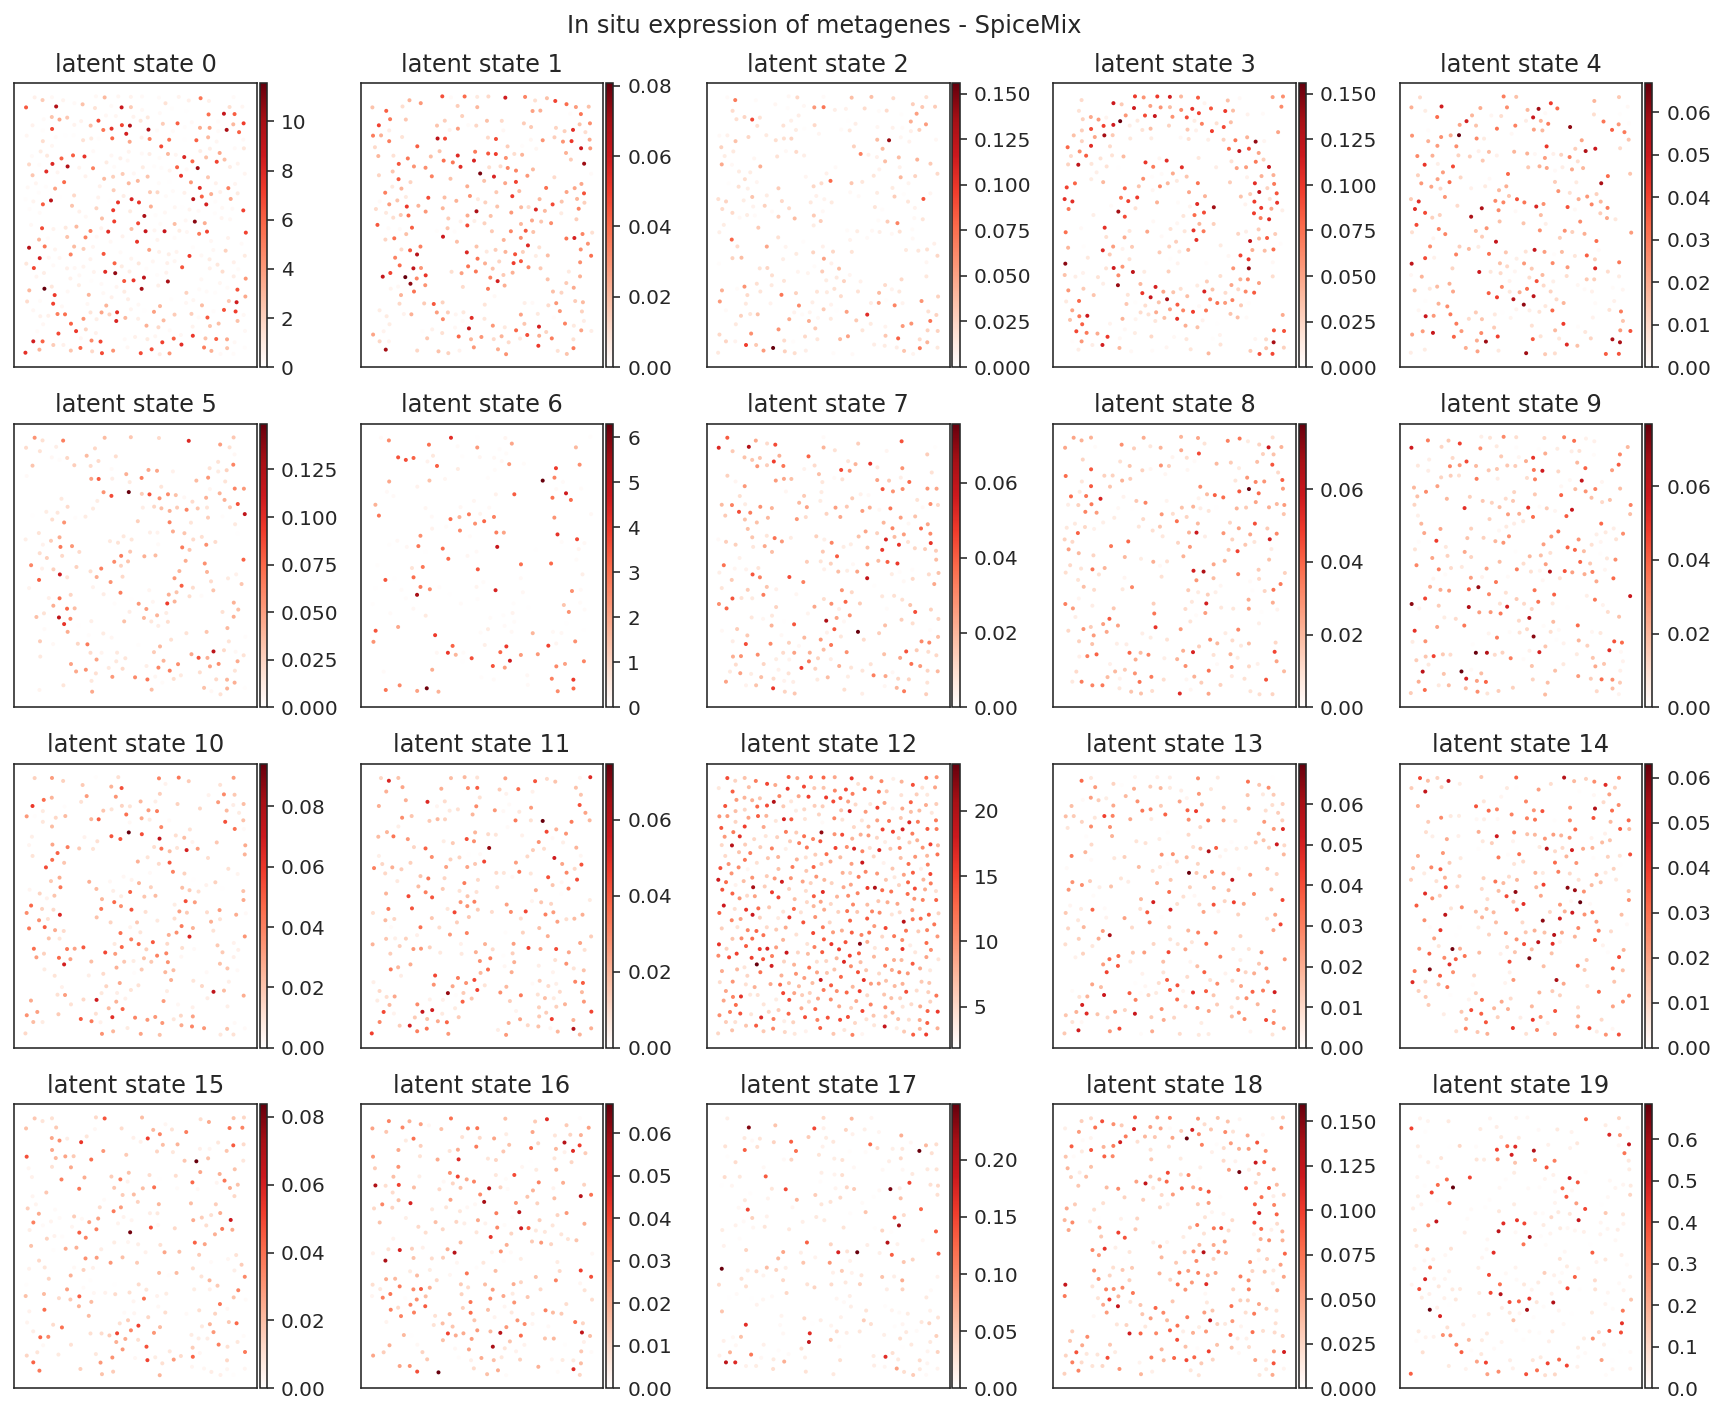

In [8]:
# We ovrlap latent states on the spatial space
# SpiceMix metagenes are expected to show clearer spatial patterns with less background expressions
segmentdata = copy.deepcopy(plt.get_cmap('Reds')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    s=1, # change dot size here
    cmap=cm,
    repli=0,
#     repli='visual_1020_20180410-BY3_1kgenes',
)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('In situ expression of metagenes - SpiceMix', y=.92)
obj_SpiceMix.visualizeFeaturesSpace(axes, **kwargs)
plt.show()

Text(0.5, 1.0, 'NMF clusters')

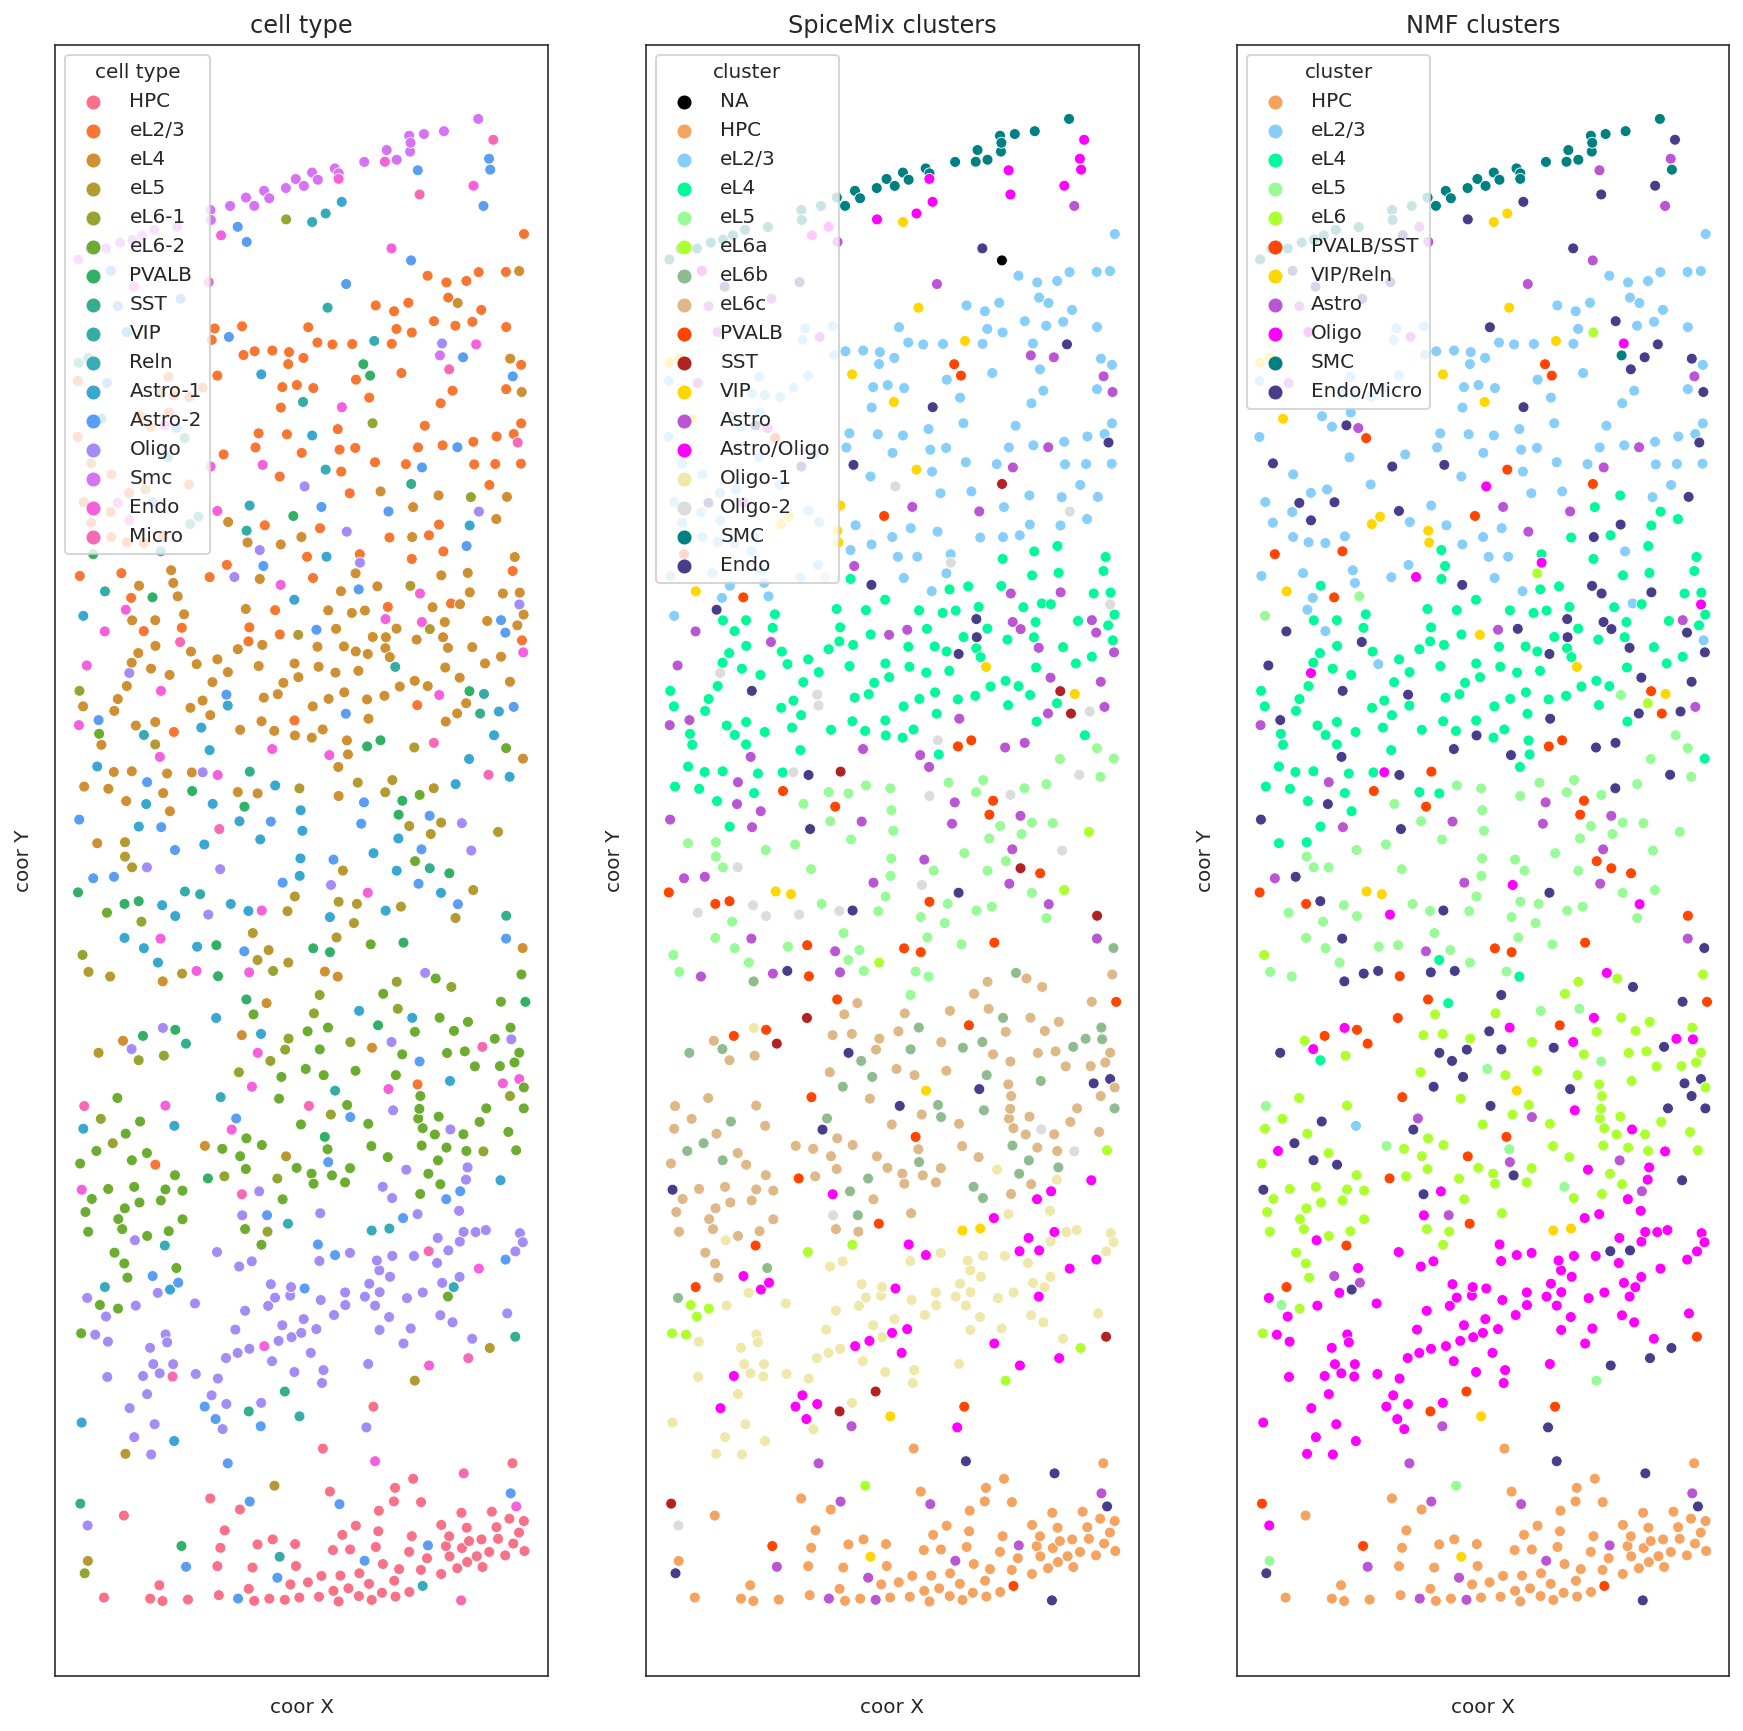

In [9]:
# We ovrlap cell types and SpiceMix/NMF clusters on the spatial space
kwargs = dict(
    s=30, # change dot size here
    repli=0,
#     repli='visual_1020_20180410-BY3_1kgenes',
)

# # Result.visualizeFeaturesSpace is a wraper of Result.visualizeFeatureSpace and handles the custom order of metagenes
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
obj_SpiceMix.visualizeFeaturesSpace(
    axes[[0, 1]], ['cell type', 'cluster'], key_x='coor X', key_y='coor Y', **kwargs,
)
obj_NMF.visualizeFeatureSpace(axes[2], 'cluster'  , key_x='coor X', key_y='coor Y', **kwargs)
axes[1].set_title('SpiceMix clusters')
axes[2].set_title('NMF clusters')

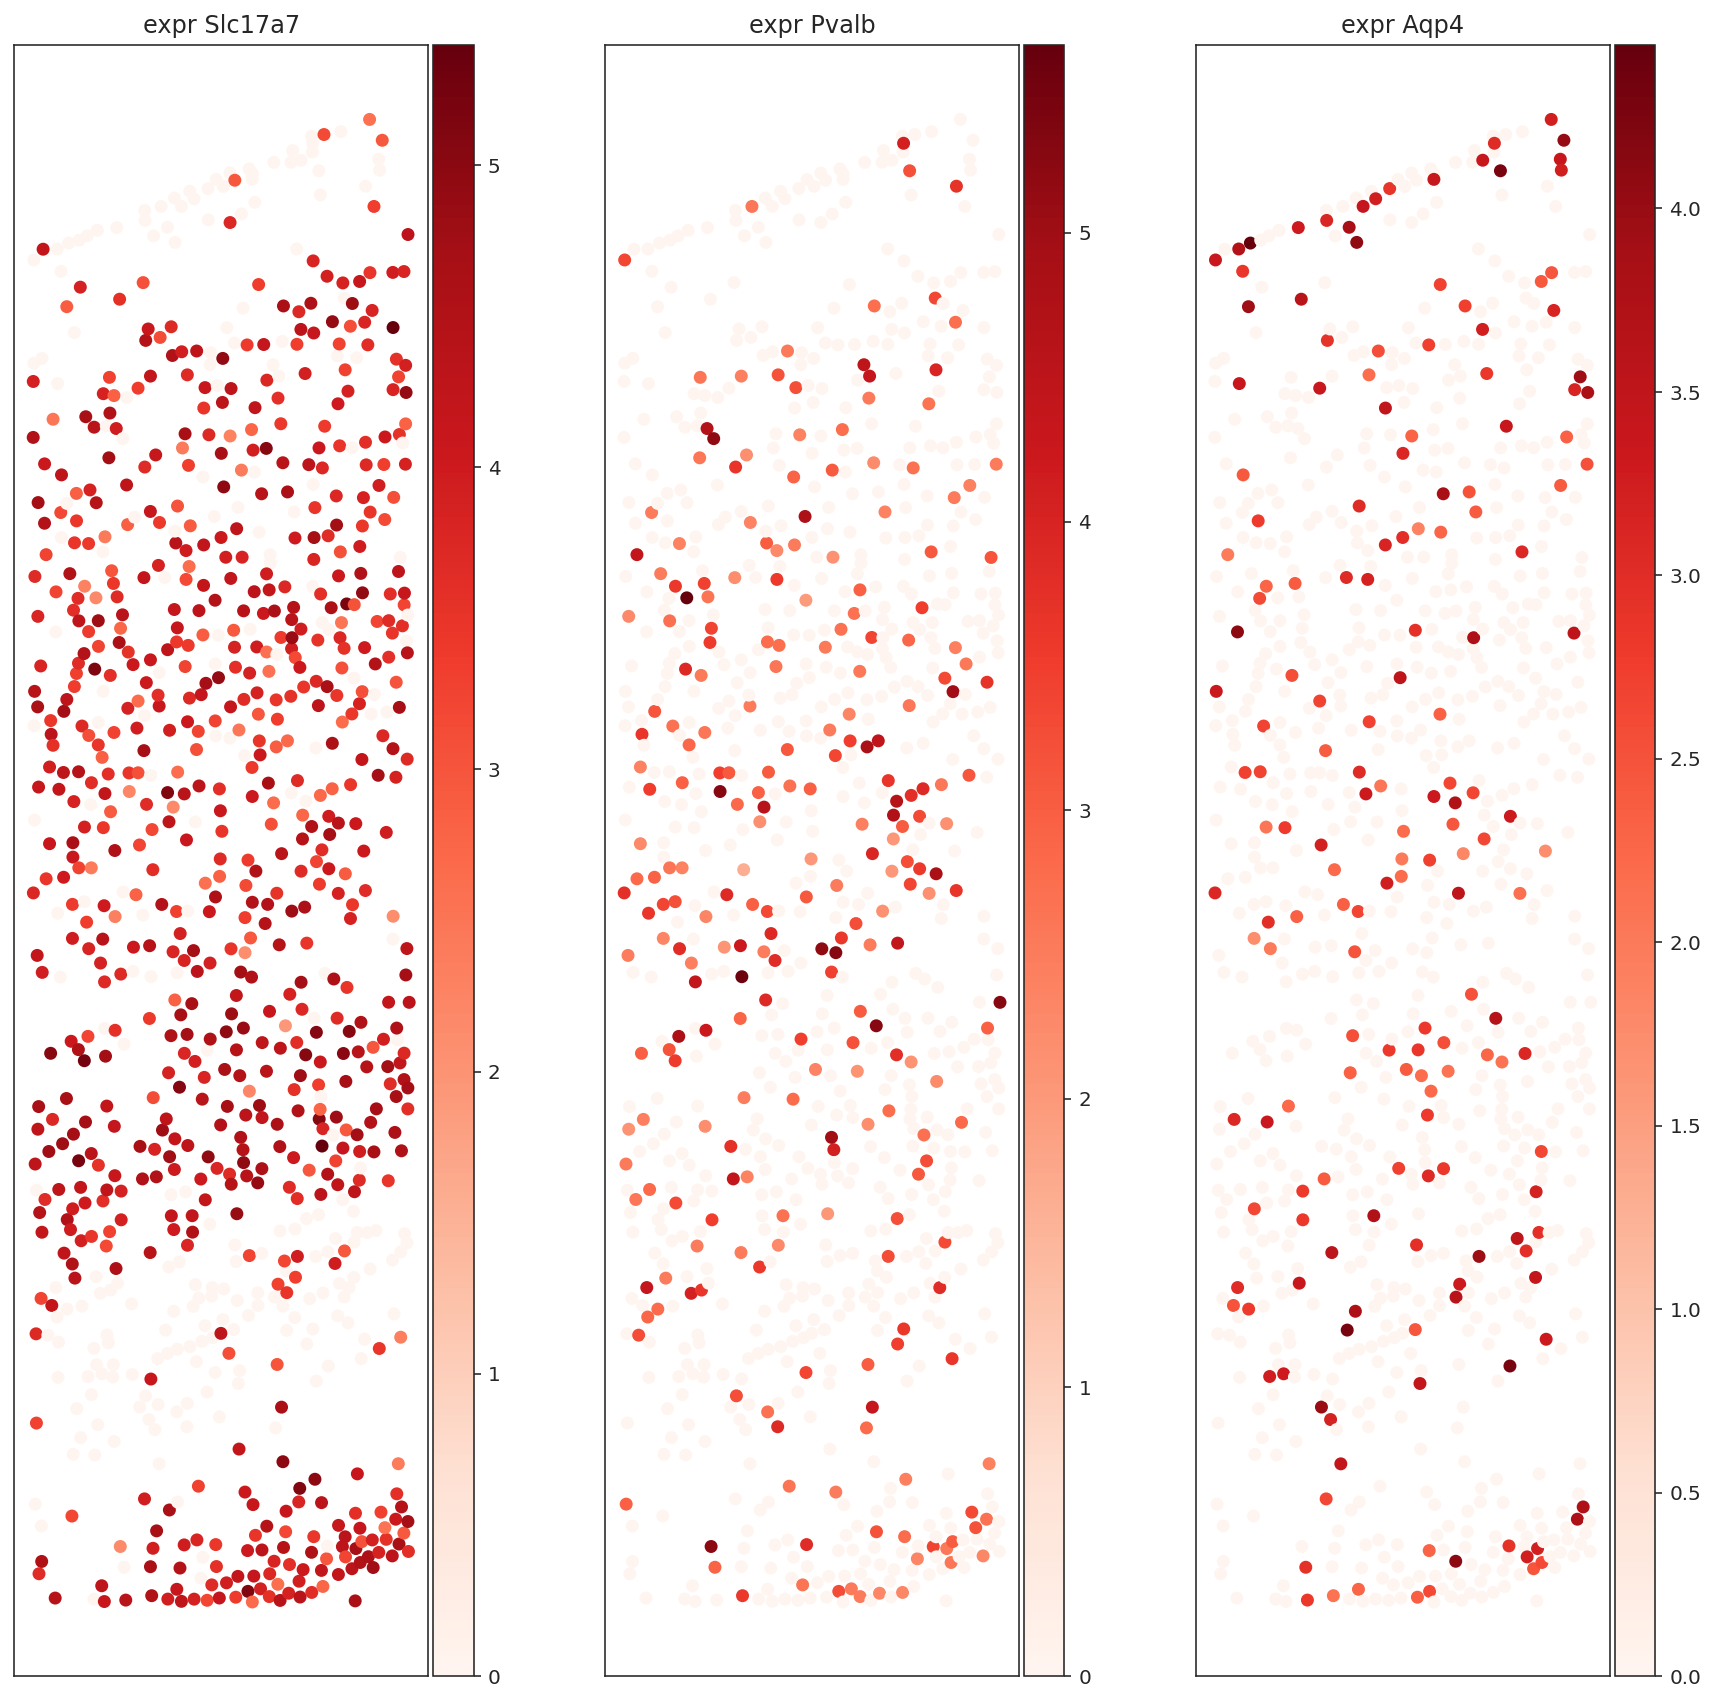

In [10]:
# We ovrlap the expression levels of a few genes on the spatial space
# String 'expr ' (including the space) needs to be prepended to gene ID
kwargs = dict(
    s=30, # change dot size here
    cmap=plt.get_cmap('Reds'),
    repli=0,
#     repli='visual_1020_20180410-BY3_1kgenes',
)

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
obj_SpiceMix.visualizeFeaturesSpace(
    axes, ['expr Slc17a7', 'expr Pvalb', 'expr Aqp4'], key_x='coor X', key_y='coor Y', **kwargs,
)

In [11]:
# do dimension reduction by UMAP
kwargs=dict(
    n_components=2,
    n_neighbors=30,
    min_dist=0.2,
    random_state=0,
)
obj_SpiceMix.UMAP(**kwargs)
obj_NMF     .UMAP(**kwargs)
# This is a wrapper of UMAP.umap
# Results are stored in columns 'UMAP 1', 'UMAP 2', and so on

Text(0.5, 1.0, 'Replicates')

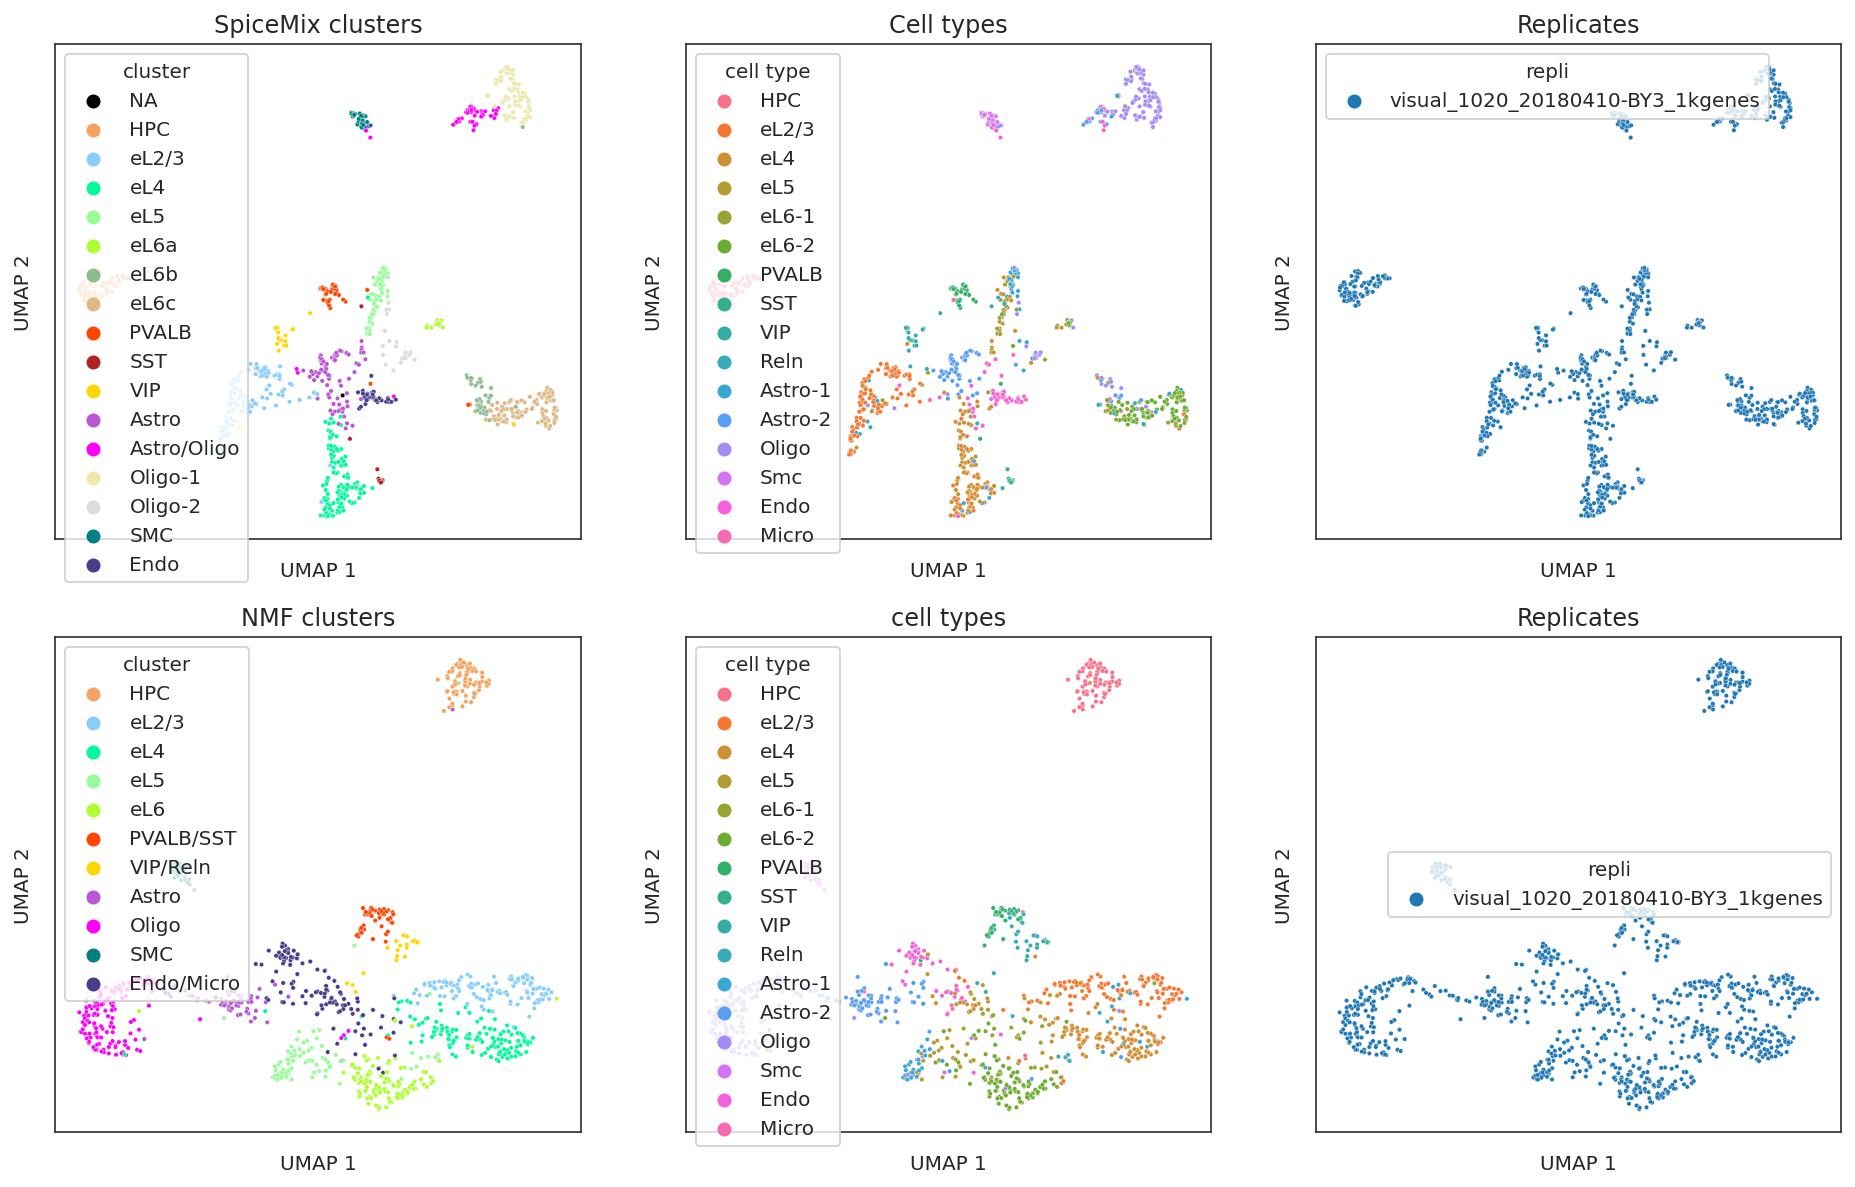

In [12]:
# Visualize cells in the latent space colored by
#   SpiceMix/NMF clusters (cluster)
#   cell types from the original analysis (cell type)
#   replicates (repli)
# Result.visualizeFeaturesSpace is a wraper of Result.visualizeFeatureSpace and handles the custom order of metagenes
kwargs = dict(s=5)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
obj_SpiceMix.visualizeFeatureSpace(axes[0, 0], 'cluster'  , key_x='UMAP 1', key_y='UMAP 2', **kwargs)
obj_SpiceMix.visualizeFeatureSpace(axes[0, 1], 'cell type', key_x='UMAP 1', key_y='UMAP 2', **kwargs)
obj_SpiceMix.visualizeFeatureSpace(axes[0, 2], 'repli'    , key_x='UMAP 1', key_y='UMAP 2', **kwargs)
obj_NMF.visualizeFeaturesSpace(
    axes[1], ['cluster', 'cell type', 'repli'],
    key_x='UMAP 1', key_y='UMAP 2', **kwargs,
)
axes[0, 0].set_title('SpiceMix clusters')
axes[0, 1].set_title('Cell types')
axes[0, 2].set_title('Replicates')
axes[1, 0].set_title('NMF clusters')
axes[1, 1].set_title('cell types')
axes[1, 2].set_title('Replicates')

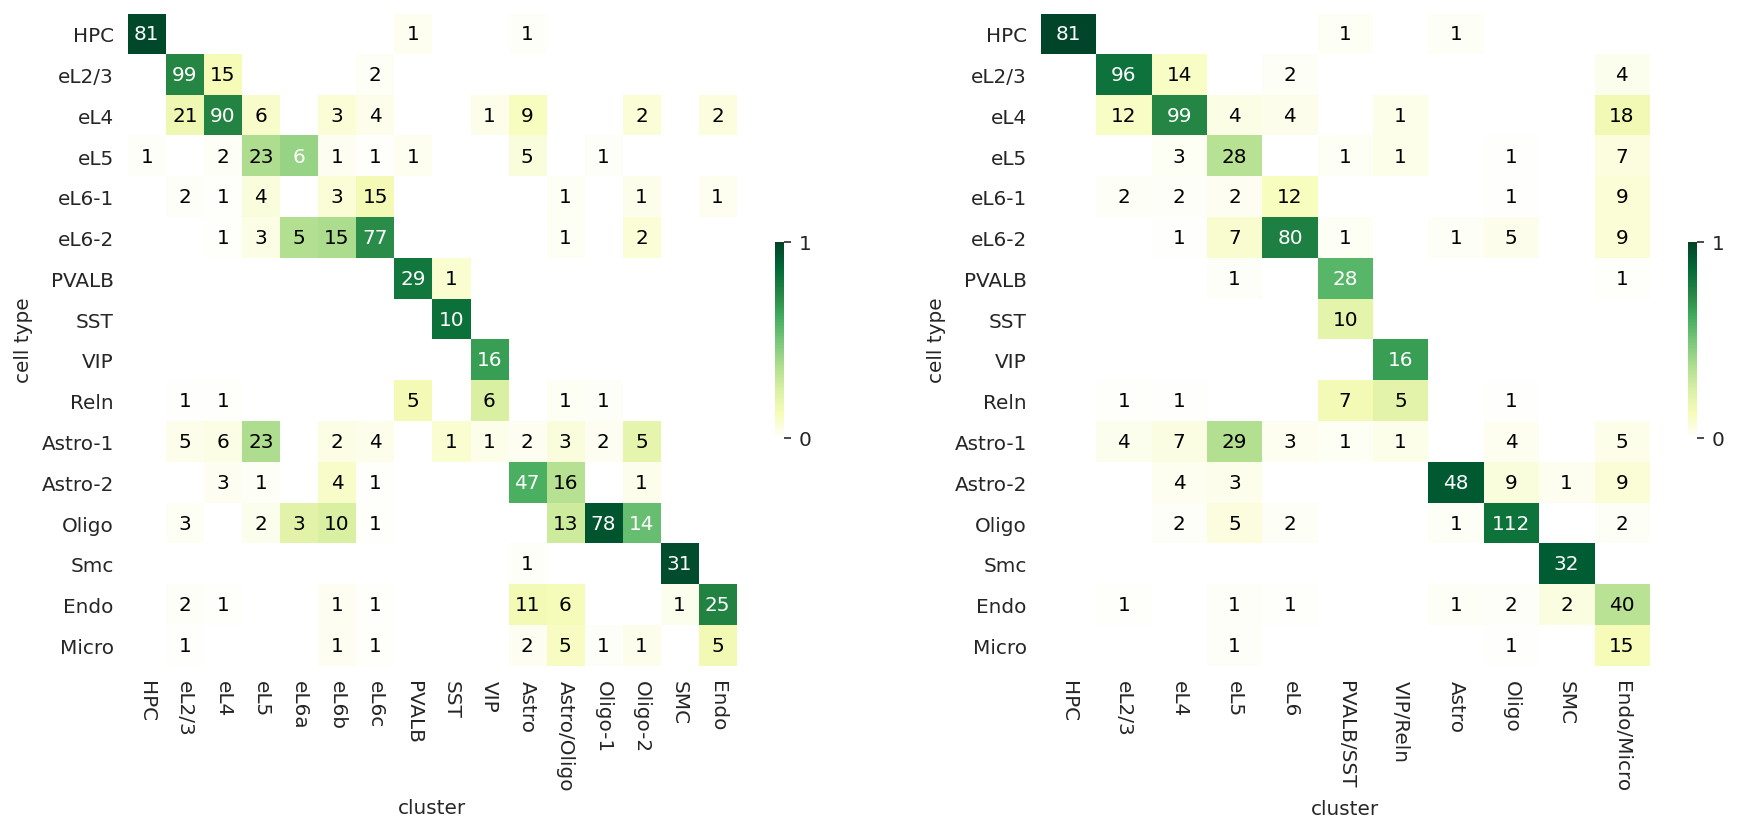

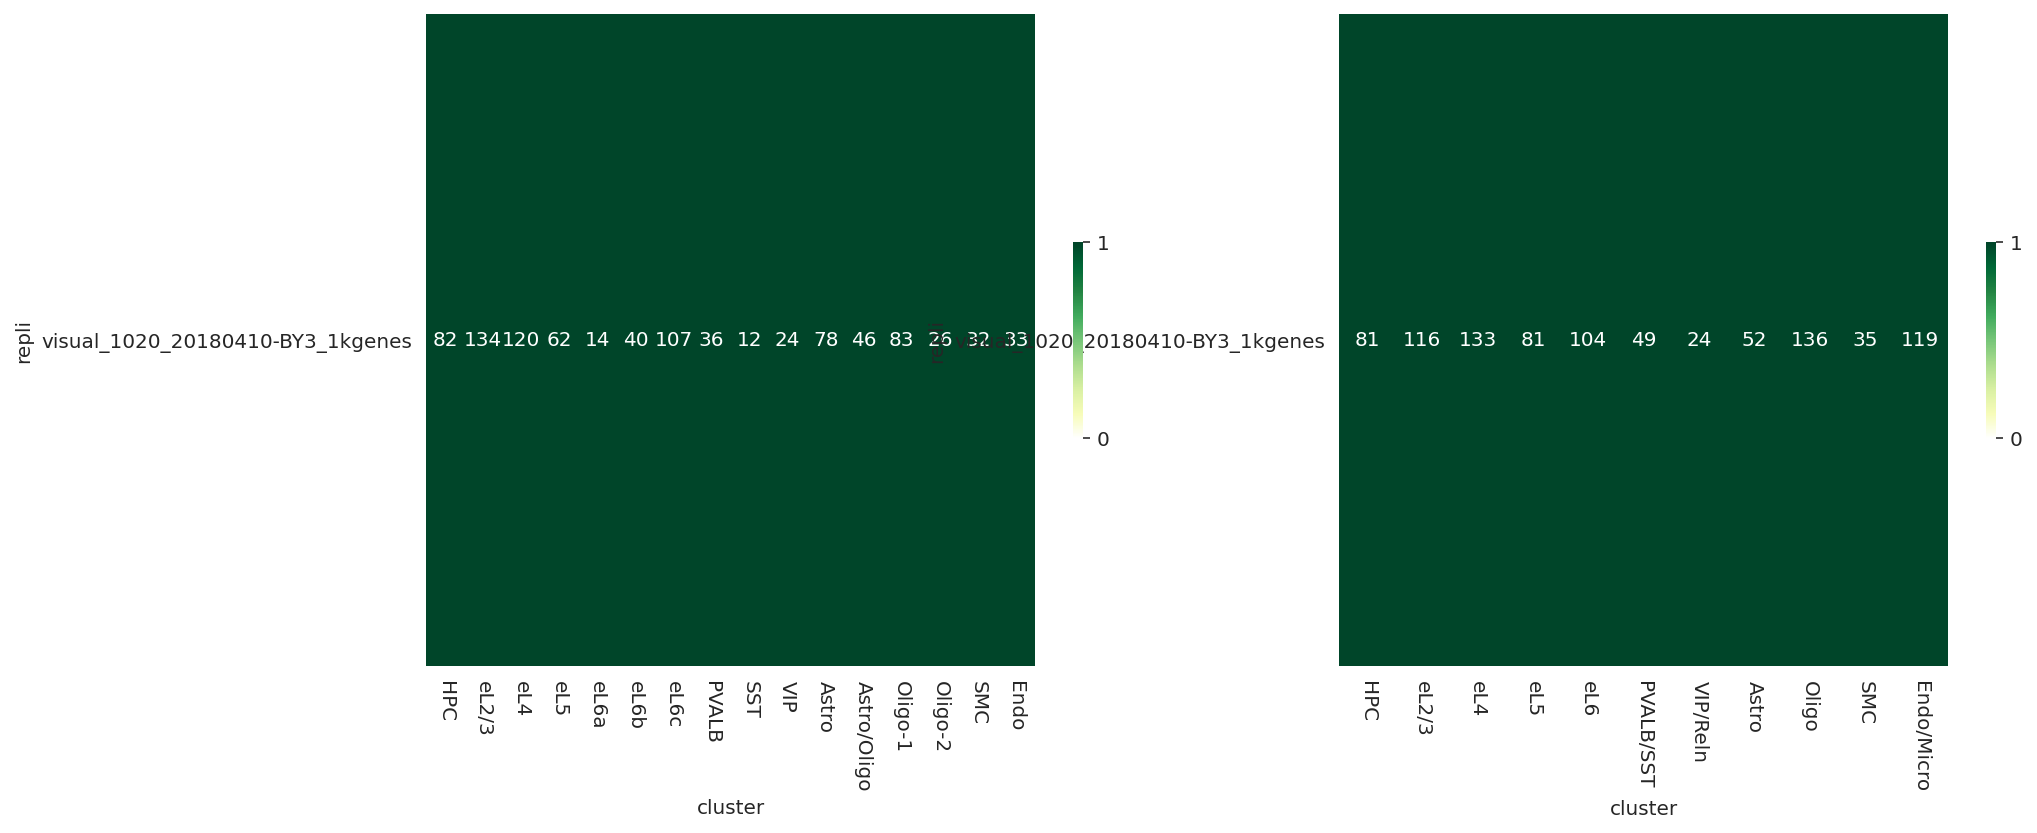

In [13]:
segmentdata = copy.deepcopy(plt.get_cmap('YlGn')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)

# compare SpiceMix/NMF clusters with the cell types from the original analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeLabelEnrichment(axes[0], **kwargs, ignores_x={'NA'})
obj_NMF     .visualizeLabelEnrichment(axes[1], **kwargs)

# the distribution of SpiceMix/NMF clusters in different replicates
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeLabelEnrichment(axes[0], **kwargs, key_x='cluster', key_y='repli', ignores_x={'NA'})
obj_NMF     .visualizeLabelEnrichment(axes[1], **kwargs, key_x='cluster', key_y='repli')

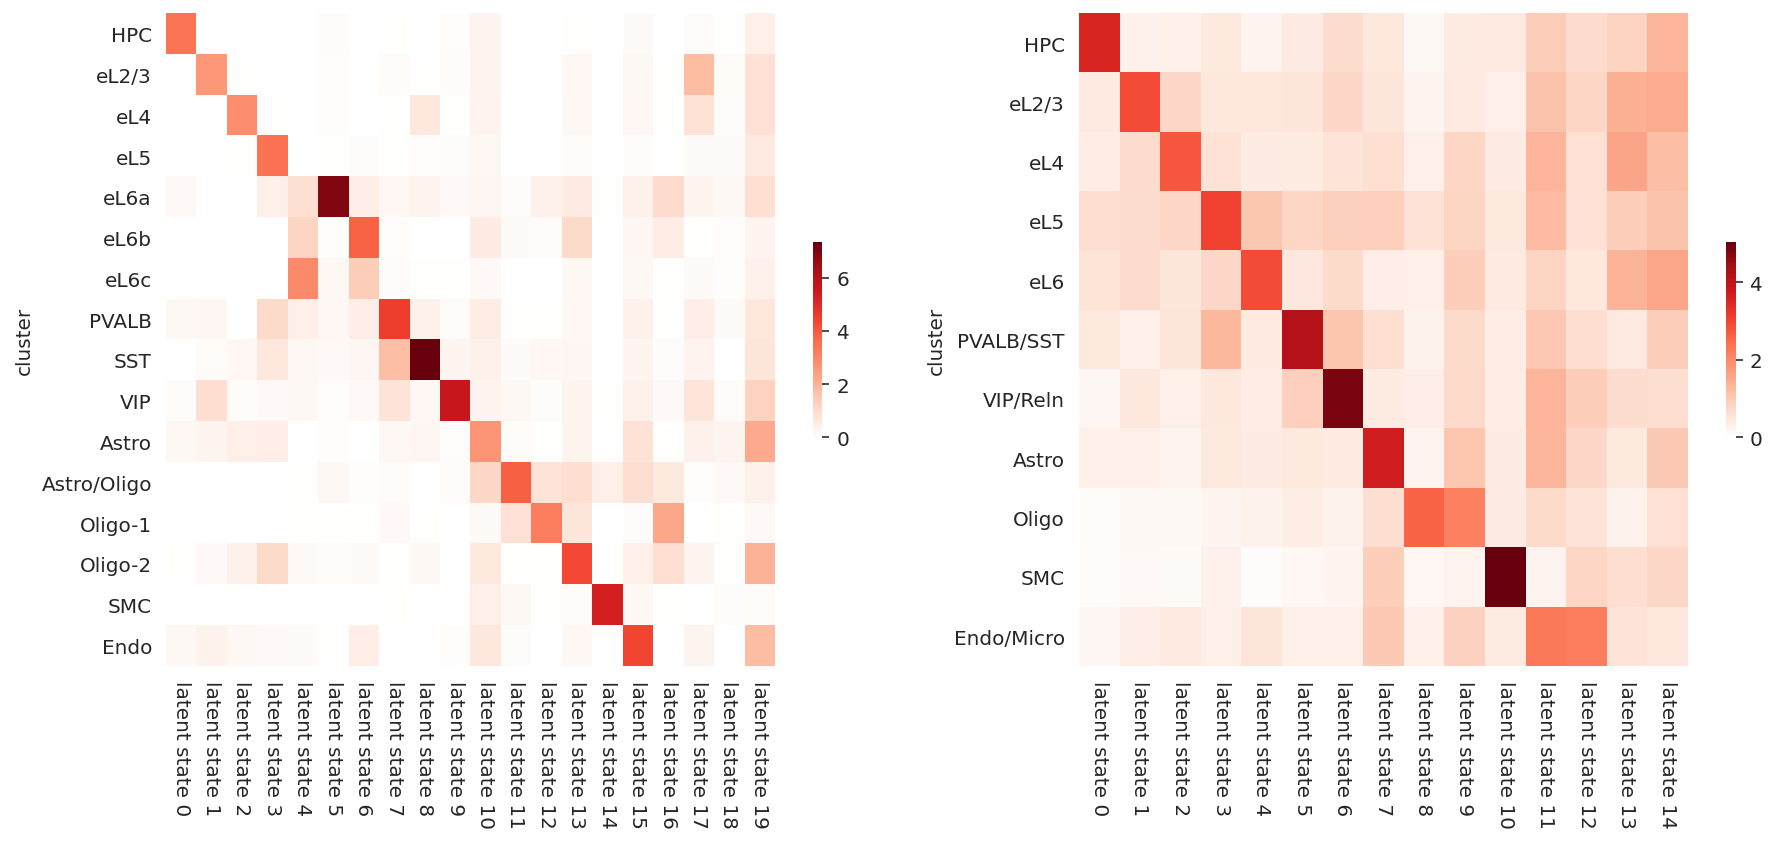

In [14]:
segmentdata = copy.deepcopy(plt.get_cmap('Reds')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs=dict(
    cmap=cm,
)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeFeatureEnrichment(
    axes[0], **kwargs, ignores_y=['NA'],
    normalizer_raw=StandardScaler(with_mean=False).fit_transform,
)
obj_NMF     .visualizeFeatureEnrichment(
    axes[1], **kwargs,
    normalizer_raw=StandardScaler(with_mean=False).fit_transform,
)

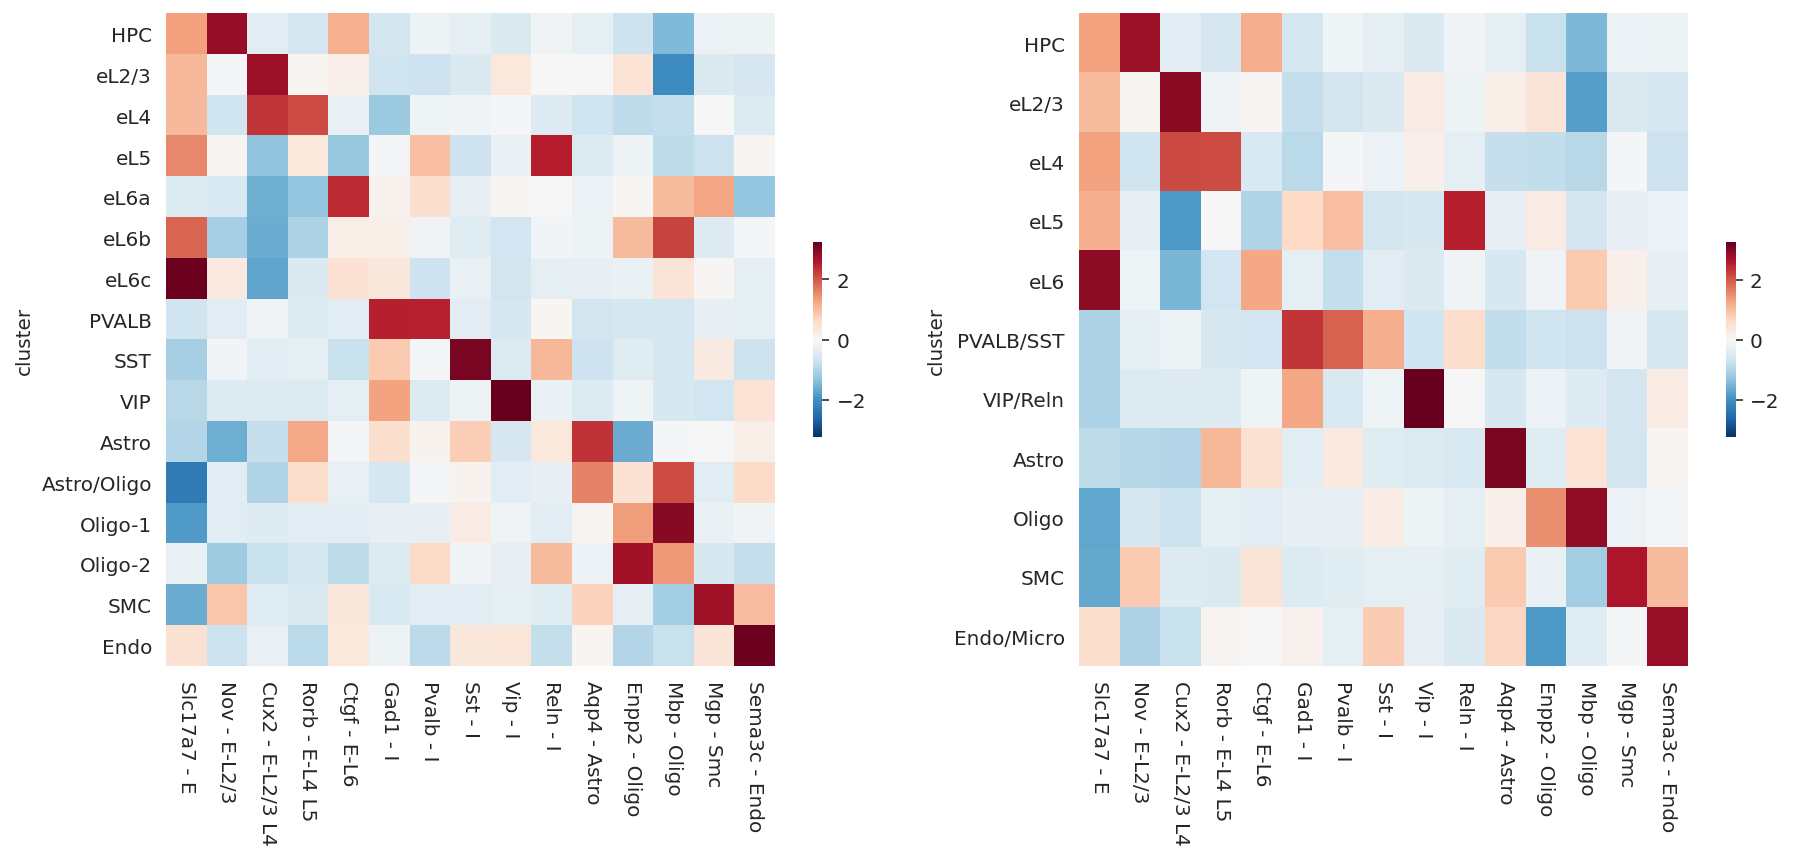

In [15]:
segmentdata = copy.deepcopy(plt.get_cmap('RdBu')._segmentdata)
for key in ['red', 'green', 'blue']:
    segmentdata[key] = [(1.-i, k, j) for (i, j, k) in segmentdata[key][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs=dict(
    cmap=cm,
)

# In the first column are the gene IDs, and in the second column are annotations, 
#   which are cell types in this example
gene_list_plot = np.array([
    ('Slc17a7',	'E'), # putative marker of all excitatory neural types
    ('Nov',		'E-L2/3'), # STARmap, Fig. 2J
    ('Cux2',	'E-L2/3 L4'), # STARmap, Fig. 2J
    ('Rorb',	'E-L4 L5'), # STARmap, Fig. 2J
    ('Ctgf',	'E-L6'), # STARmap, Fig. 2J & tasic
    
    ('Gad1',	'I'), # putative marker of all inhibitory neural types
    ('Pvalb',	'I'), # putative marker of PVALB subtype
    ('Sst',		'I'), # putative marker of SST subtype
    ('Vip',		'I'), # putative marker of VIP subtype
    ('Reln',	'I'),
    
    ('Aqp4',	'Astro'), # tasic
    ('Enpp2',	'Oligo'), # STARmap Fig. S6B
    ('Mbp',		'Oligo'), # tasic
    ('Mgp',		'Smc'), # STARmap Fig. S6B
    ('Sema3c',	'Endo'), # STARmap Fig. S6B
])
# Extract gene IDs and prepend string 'expr '
keys_x = [f'expr {_[0]}' for _ in gene_list_plot]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeFeatureEnrichment(
    axes[0], keys_x=keys_x, **kwargs, ignores_y=['NA'],
    normalizer_raw=StandardScaler().fit_transform,
    normalizer_avg=lambda x: StandardScaler().fit_transform(x.T).T,
)
obj_NMF     .visualizeFeatureEnrichment(
    axes[1], keys_x=keys_x, **kwargs,
    normalizer_raw=StandardScaler().fit_transform,
    normalizer_avg=lambda x: StandardScaler().fit_transform(x.T).T,
)
for ax in axes:
    ax.set_xticklabels(' - '.join(_) for _ in gene_list_plot)

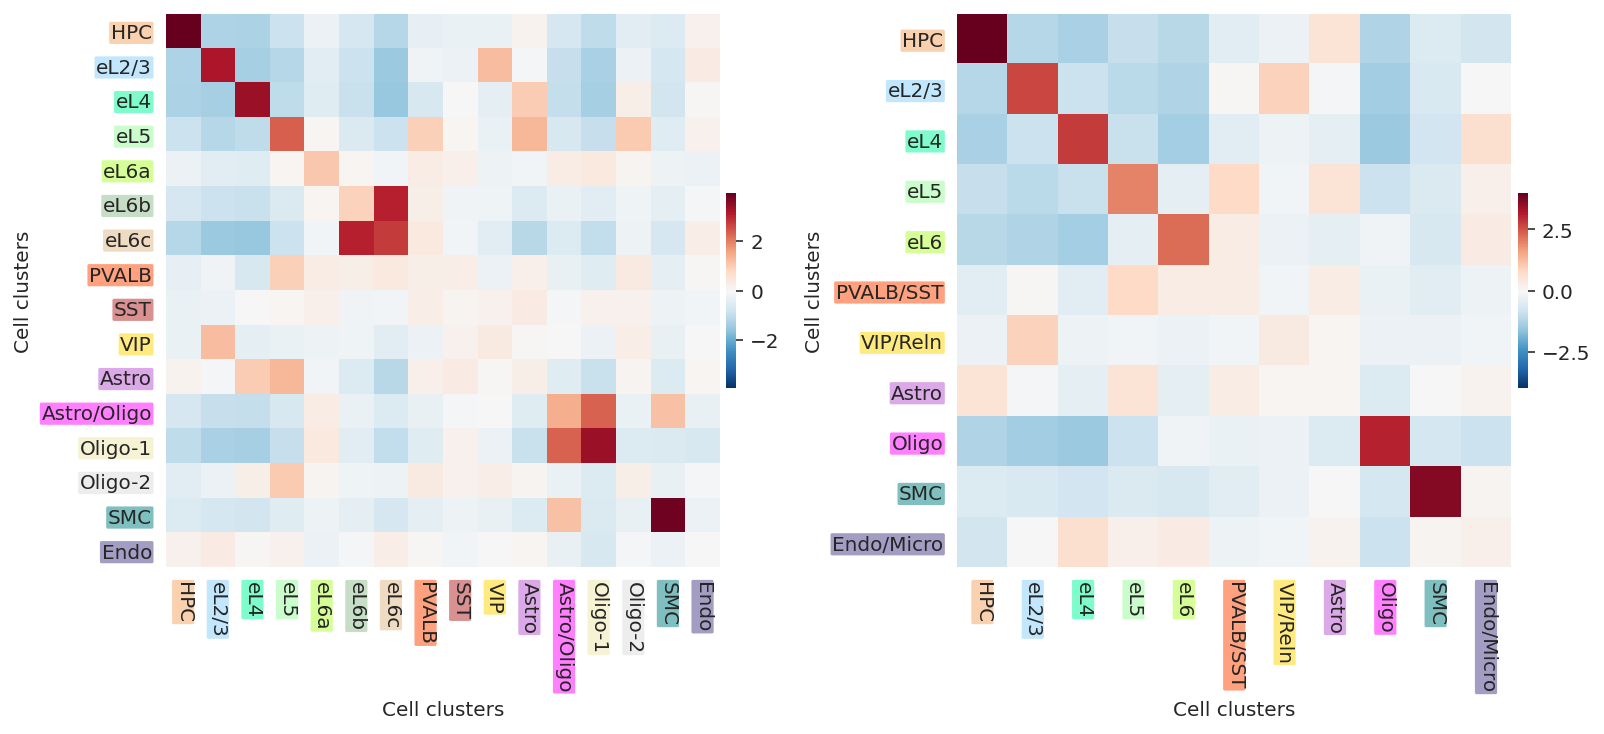

In [16]:
# plot the empirical affinity between cell types
segmentdata = copy.deepcopy(plt.get_cmap('RdBu')._segmentdata)
for channel in ['red', 'green', 'blue']:
    segmentdata[channel] = [(1.-i, k, j) for (i, j, k) in segmentdata[channel][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
obj_SpiceMix.plotAffinityClusters(axes[0], ignores={'NA'}, **kwargs)
obj_NMF     .plotAffinityClusters(axes[1], ignores={'NA'}, **kwargs)

Iteration 200
Iteration 200


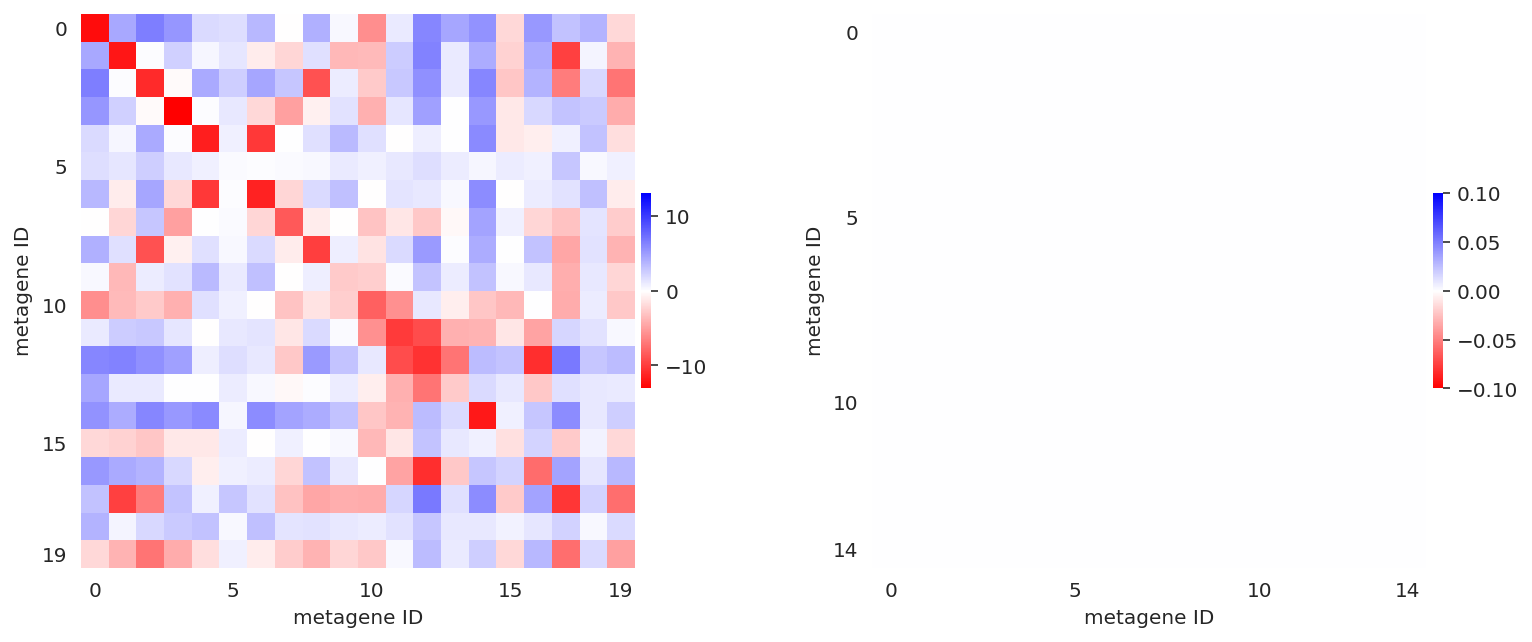

In [17]:
segmentdata = copy.deepcopy(plt.get_cmap('bwr')._segmentdata)
for key in ['red', 'green', 'blue']:
    segmentdata[key] = [(1.-i, k, j) for (i, j, k) in segmentdata[key][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
obj_SpiceMix.plotAffinityMetagenes(axes[0], iteration=-1, **kwargs)